In [8]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import json
import os
from helper import train_VAE 
X_train = pd.read_csv('../datasets/Bikerental/X_train.csv',index_col=0)  
X_test = pd.read_csv('../datasets/Bikerental/X_test.csv',index_col=0)  
y_train = pd.read_csv('../datasets/Bikerental/y_train.csv',index_col=0)  
y_test = pd.read_csv('../datasets/Bikerental/y_test.csv',index_col=0) 
X_train_with_confounder=X_train.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])
X_test_with_confounder=X_test.drop(columns=['season_SPRING','season_FALL','season_SUMMER','season_WINTER'])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_with_confounder)
X_test_scaled = scaler.transform(X_test_with_confounder)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [9]:
def custom_scale(data, min_val=0, max_val=10000):
    scaled_data = (data - min_val) / (max_val - min_val)
    return scaled_data

# Apply custom scaling to y_train and y_test
y_train_scaled = custom_scale(y_train)
y_test_scaled = custom_scale(y_test)

In [10]:
y_train_scaled

,cnt
59,0.1851
700,0.5191
662,0.7693
688,0.5499
222,0.4792
...,...
422,0.4322
95,0.2808
294,0.4308
202,0.3387


In [14]:
import itertools

# Define the ranges for your parameters
x_dim_values = [X_train_with_confounder.shape[1]]
z_dim_values = [4]
zz_dim_values = [1]
encoder_z_layers_values = [[12, 12, 12]]
encoder_zz_layers_values = [[5, 5, 5]]
#decoder_layers_values = [[14,X_train_with_confounder.shape[1]],[32, 32,X_train_with_confounder.shape[1]],[128,128,128,X_train_with_confounder.shape[1]]]
fc_z_to_y_layers_values = [[28, 28, 1]]

# Get all combinations
configurations = list(itertools.product(x_dim_values, z_dim_values, zz_dim_values, encoder_z_layers_values, encoder_zz_layers_values, fc_z_to_y_layers_values))

# Convert to a list of dictionaries
config_dicts = [{'x_dim': x_dim, 'z_dim': z_dim, 'zz_dim': zz_dim, 'encoder_z_layers': encoder_z_layers, 'encoder_zz_layers': encoder_zz_layers, 'decoder_layers': encoder_z_layers+ [x_dim], 'fc_z_to_y_layers': fc_z_to_y_layers} for x_dim, z_dim, zz_dim, encoder_z_layers, encoder_zz_layers, fc_z_to_y_layers in configurations]
print(config_dicts)
# Define betas
BETAS=[
    #{'b1': 6, 'b2': 1, 'b3': 1, 'b4': 6,'b5':1},
    #{'b1': 1, 'b2': 1, 'b3': 1, 'b4': 1000,'b5':1},
    #{'b1': 100, 'b2': 1, 'b3': 100, 'b4': 100,'b5':1},
    #{'b1': 100,'b2': 1, 'b3': 1, 'b4': 10,'b5':1},  
    #{'b1': 10000, 'b2': 1, 'b3': 1, 'b4': 10000,'b5':1},
    {'b1': 10000, 'b2': 1, 'b3':1, 'b4': 1000,'b5':1}
]
import itertools

# Define the ranges for your parameters
lr_values = [1e-3]
batch_size_values = [32]
num_epochs_values = [700]

# Get all combinations
configs = list(itertools.product(config_dicts, BETAS, lr_values, batch_size_values, num_epochs_values))

# Convert to a list of dictionaries
configs = [{'config': config, 'beta': beta, 'lr': lr, 'batch_size': bs, 'num_epochs': epochs} for config, beta, lr, bs, epochs in configs]
print(len(configs))

[{'x_dim': 10, 'z_dim': 4, 'zz_dim': 1, 'encoder_z_layers': [12, 12, 12], 'encoder_zz_layers': [5, 5, 5], 'decoder_layers': [12, 12, 12, 10], 'fc_z_to_y_layers': [28, 28, 1]}]
1


{'config': {'x_dim': 10, 'z_dim': 4, 'zz_dim': 1, 'encoder_z_layers': [12, 12, 12], 'encoder_zz_layers': [5, 5, 5], 'decoder_layers': [12, 12, 12, 10], 'fc_z_to_y_layers': [28, 28, 1]}, 'beta': {'b1': 10000, 'b2': 1, 'b3': 1, 'b4': 1000, 'b5': 1}, 'lr': 0.001, 'batch_size': 32, 'num_epochs': 700}
False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 12]             132
              ReLU-2                   [-1, 12]               0
            Linear-3                   [-1, 12]             156
              ReLU-4                   [-1, 12]               0
            Linear-5                   [-1, 12]             156
              ReLU-6                   [-1, 12]               0
            Linear-7                    [-1, 4]              52
            Linear-8                    [-1, 4]              52
            Linear-9                    [-1, 5]        

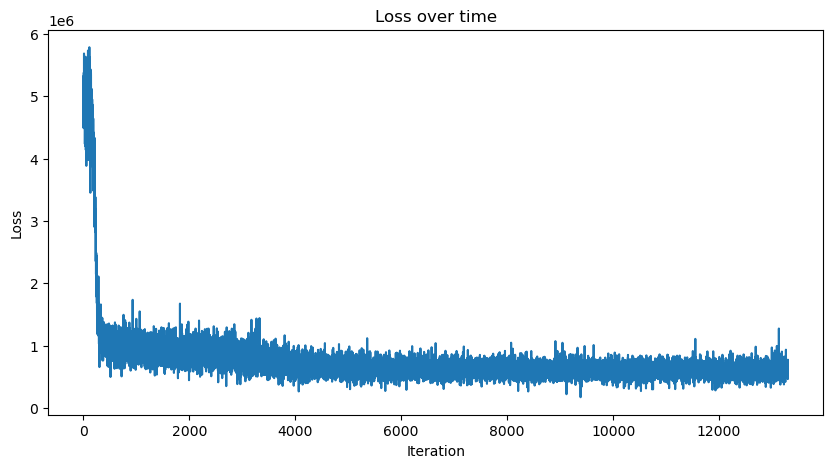

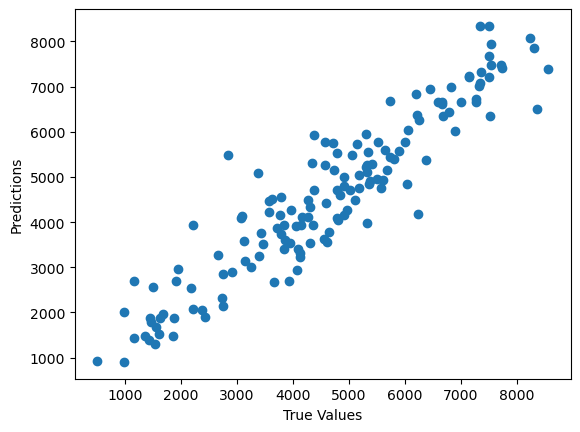

        0
0    2424
1    4966
2    7328
3    5895
4    2368
..    ...
142  6660
143  2743
144  3831
145  6241
146  5501

[147 rows x 1 columns]
     yr       temp      hum  windspeed  days_since_2011  season_FALL  \
0  2011  17.461733  89.5217  16.303713              291            1   
1  2011  26.075000  65.4583  10.374950              161            0   
2  2012  22.902500  72.2917   7.875582              642            1   
3  2011  22.119151  45.5417   9.833121              234            0   
4  2012  -2.947500  41.4583  12.374900              368            0   

   season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
0              0              0              0                0   
1              1              0              0                0   
2              0              0              0                0   
3              0              1              0                0   
4              0              0              1                0   

   workingday_WORKIN

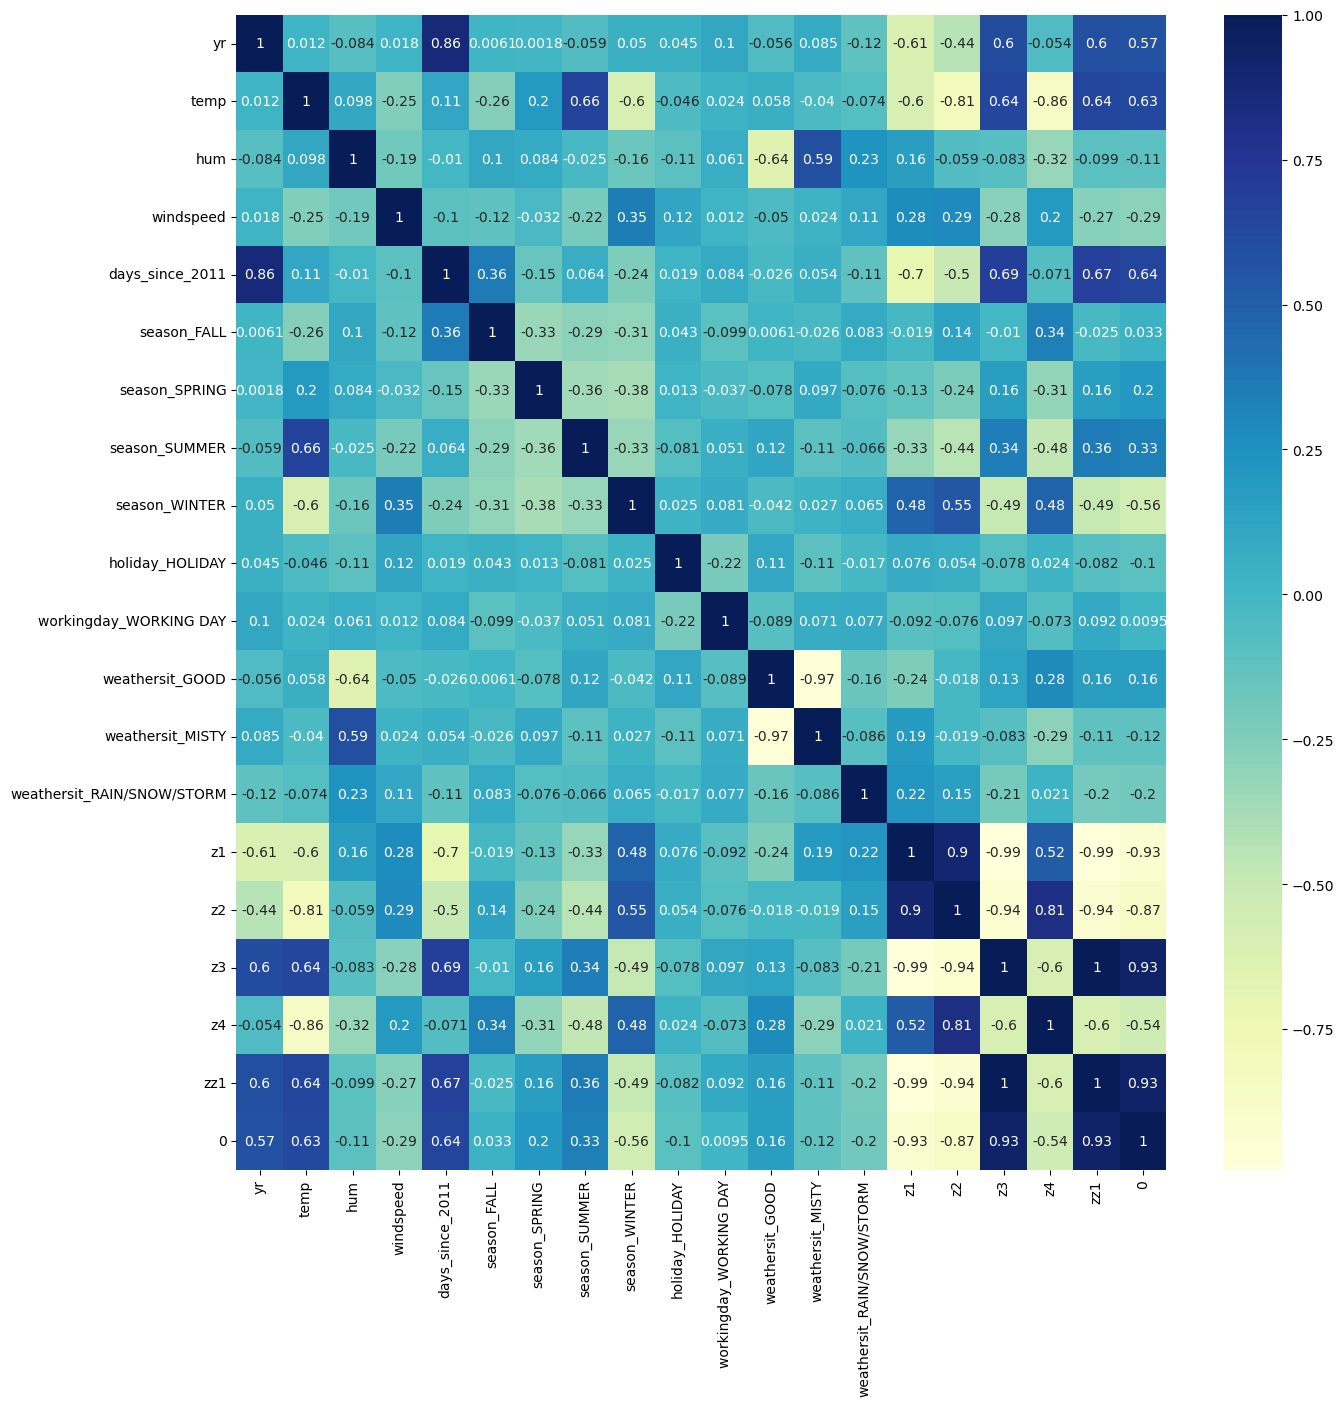

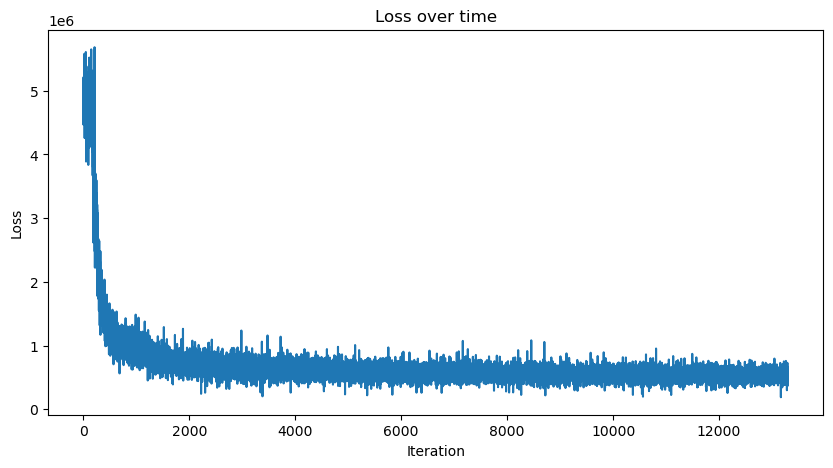

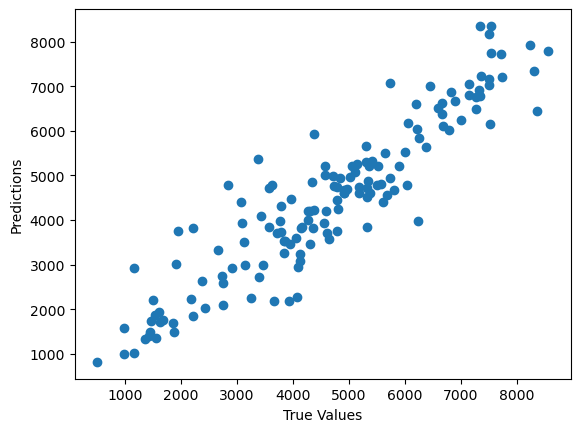

        0
0    2424
1    4966
2    7328
3    5895
4    2368
..    ...
142  6660
143  2743
144  3831
145  6241
146  5501

[147 rows x 1 columns]
     yr       temp      hum  windspeed  days_since_2011  season_FALL  \
0  2011  17.461733  89.5217  16.303713              291            1   
1  2011  26.075000  65.4583  10.374950              161            0   
2  2012  22.902500  72.2917   7.875582              642            1   
3  2011  22.119151  45.5417   9.833121              234            0   
4  2012  -2.947500  41.4583  12.374900              368            0   

   season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
0              0              0              0                0   
1              1              0              0                0   
2              0              0              0                0   
3              0              1              0                0   
4              0              0              1                0   

   workingday_WORKIN

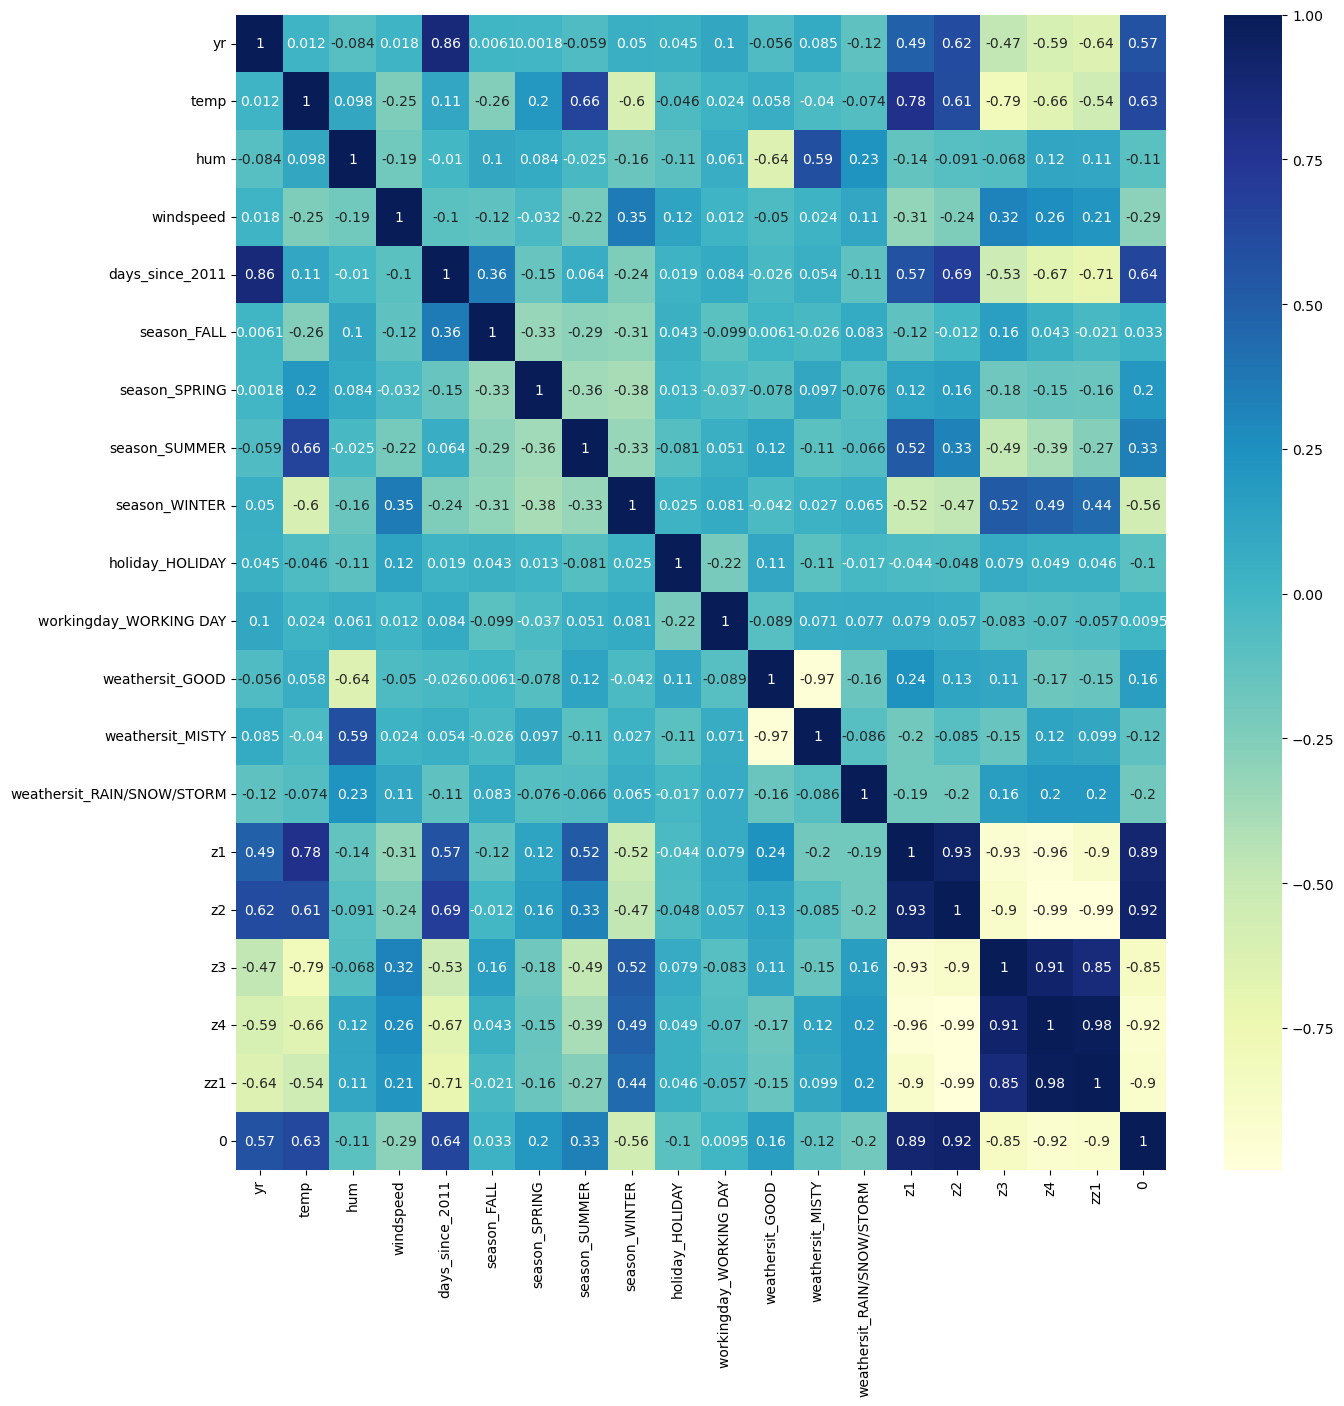

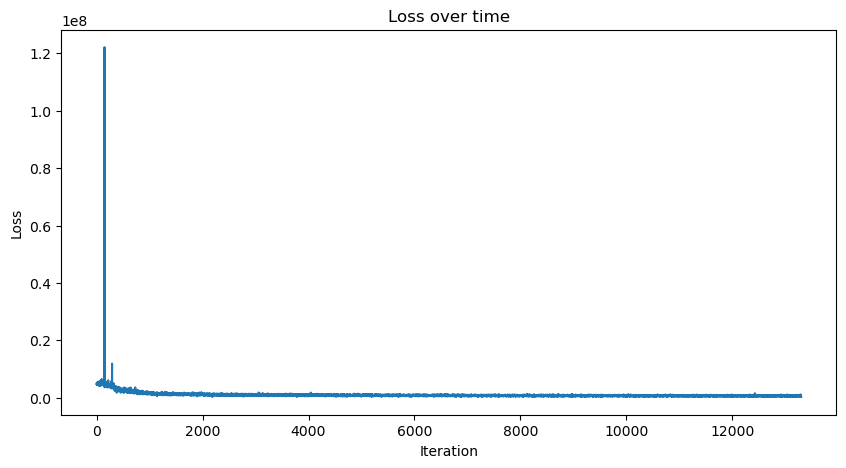

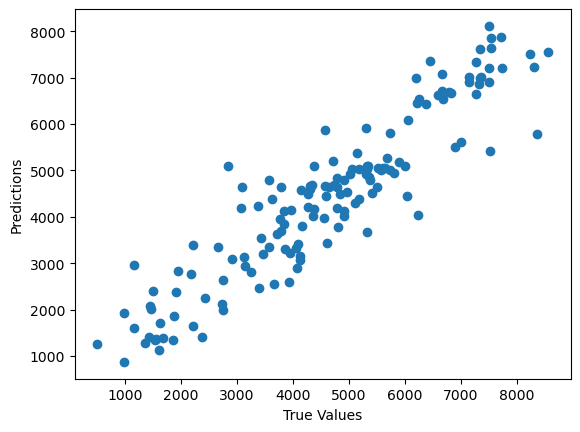

        0
0    2424
1    4966
2    7328
3    5895
4    2368
..    ...
142  6660
143  2743
144  3831
145  6241
146  5501

[147 rows x 1 columns]
     yr       temp      hum  windspeed  days_since_2011  season_FALL  \
0  2011  17.461733  89.5217  16.303713              291            1   
1  2011  26.075000  65.4583  10.374950              161            0   
2  2012  22.902500  72.2917   7.875582              642            1   
3  2011  22.119151  45.5417   9.833121              234            0   
4  2012  -2.947500  41.4583  12.374900              368            0   

   season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
0              0              0              0                0   
1              1              0              0                0   
2              0              0              0                0   
3              0              1              0                0   
4              0              0              1                0   

   workingday_WORKIN

KeyboardInterrupt: 

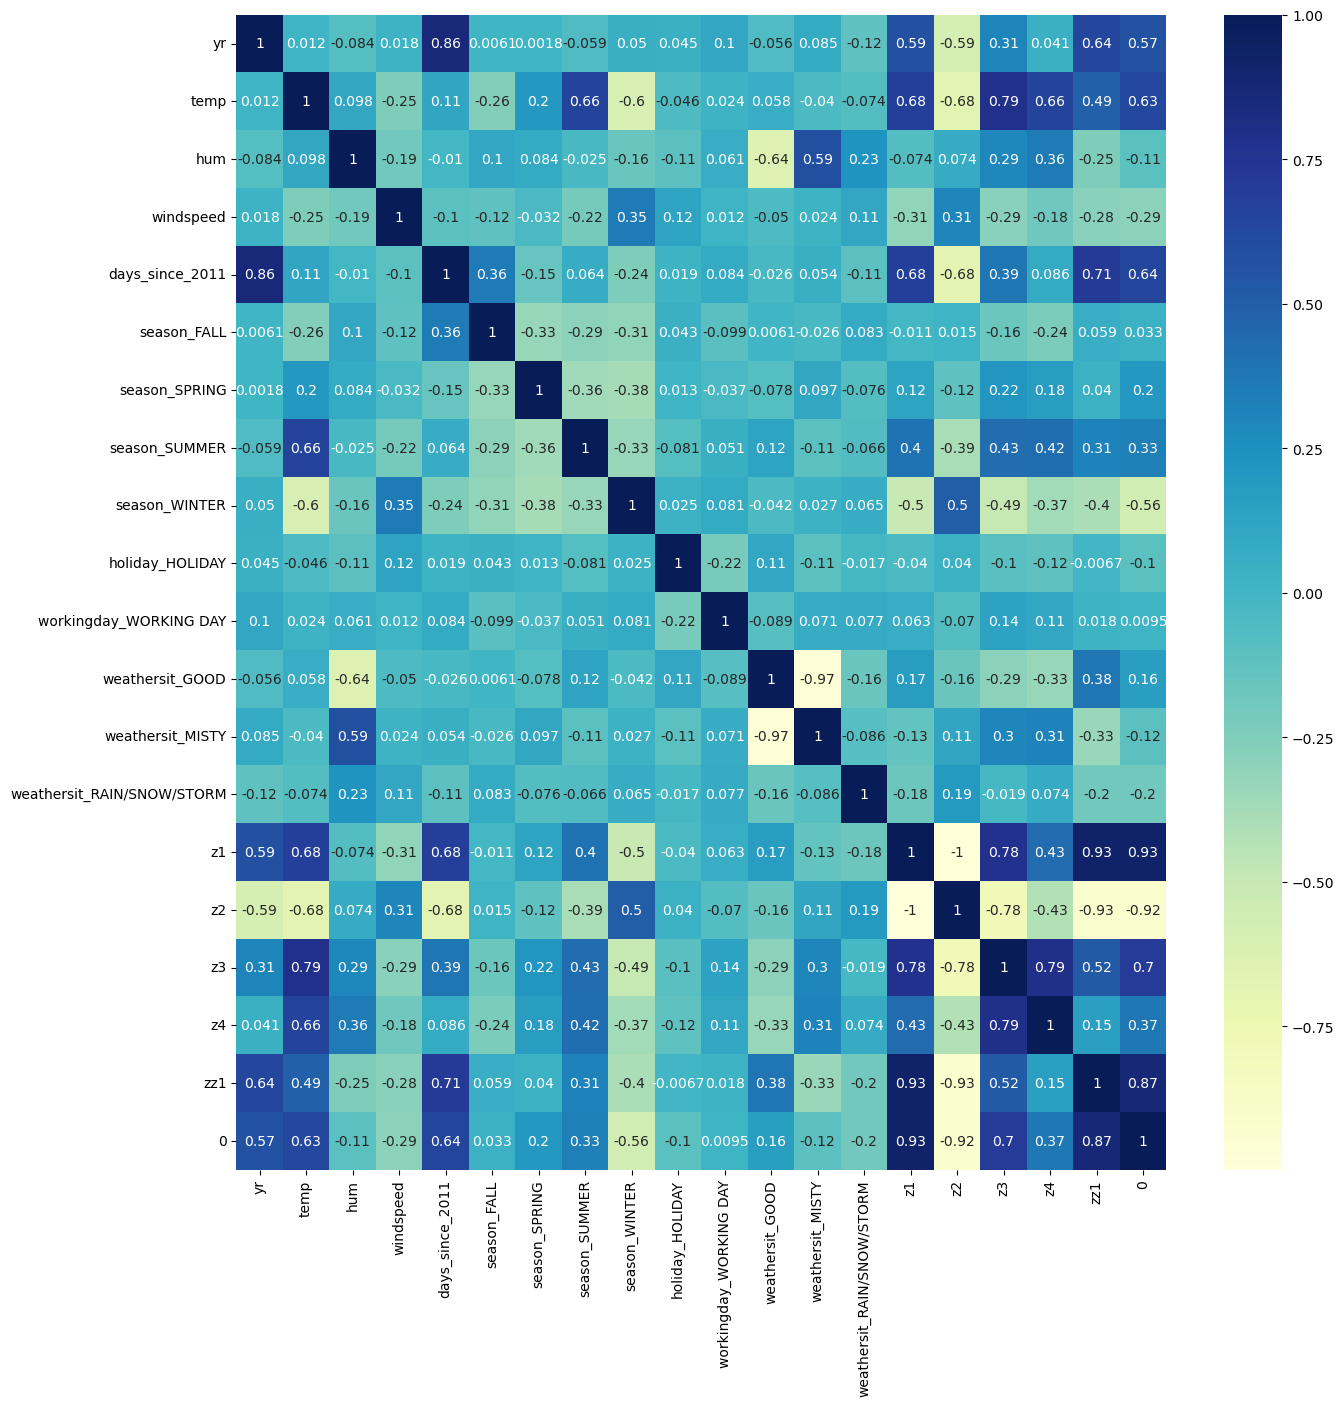

In [17]:
for i in range(5):
    mod,r,lt,ltt=train_VAE(X_train_scaled,X_test_scaled,X_test,y_train.values,y_test.values,configs[0],'./Test',save_pictures=True,freeze_weights=False)
    if r>0.84:
        dict_d=dict(configs[0])
        r2_text = str(r).replace(".", "_")
        torch.save(mod,f"./Bike_rental/Final/Bike_No_freeze_z_and_zz_to_y_R2_{r2_text}_model.zip")
        with open(f"./Bike_rental/Final/Config_Bike_No_freeze_z_and_zz_to_y_R2_{r2_text}.json", 'w') as outfile:
            json.dump(dict_d, outfile)

In [11]:
import itertools

# Define the ranges for your parameters
x_dim_values = [X_train_with_confounder.shape[1]]
z_dim_values = [4]
zz_dim_values = [1]
encoder_z_layers_values = [[128,128]]
encoder_zz_layers_values = [[5,5,5]]
#decoder_layers_values = [[14,X_train_with_confounder.shape[1]],[32, 32,X_train_with_confounder.shape[1]],[128,128,128,X_train_with_confounder.shape[1]]]
fc_z_to_y_layers_values = [[28, 28, 1]]

# Get all combinations
configurations = list(itertools.product(x_dim_values, z_dim_values, zz_dim_values, encoder_z_layers_values, encoder_zz_layers_values, fc_z_to_y_layers_values))

# Convert to a list of dictionaries
config_dicts = [{'x_dim': x_dim, 'z_dim': z_dim, 'zz_dim': zz_dim, 'encoder_z_layers': encoder_z_layers, 'encoder_zz_layers': encoder_zz_layers, 'decoder_layers': encoder_z_layers+ [x_dim], 'fc_z_to_y_layers': fc_z_to_y_layers} for x_dim, z_dim, zz_dim, encoder_z_layers, encoder_zz_layers, fc_z_to_y_layers in configurations]
print(config_dicts)
# Define betas
BETAS=[
    #{'b1': 6, 'b2': 1, 'b3': 1, 'b4': 6,'b5':1},
    #{'b1': 1, 'b2': 1, 'b3': 1, 'b4': 1000,'b5':1},
    #{'b1': 100, 'b2': 1, 'b3': 100, 'b4': 100,'b5':1},
    {'b1': 10000,'b2': 1, 'b3': 1, 'b4': 1000,'b5':1},  
    #{'b1': 10000, 'b2': 1, 'b3': 1, 'b4': 10,'b5':1},
    #{'b1': 10000, 'b2': 1, 'b3': 1, 'b4': 1,'b5':1}
]
import itertools

# Define the ranges for your parameters
lr_values = [1e-3]
batch_size_values = [32]
num_epochs_values = [700]

# Get all combinations
configs = list(itertools.product(config_dicts, BETAS, lr_values, batch_size_values, num_epochs_values))

# Convert to a list of dictionaries
configs = [{'config': config, 'beta': beta, 'lr': lr, 'batch_size': bs, 'num_epochs': epochs} for config, beta, lr, bs, epochs in configs]
print(len(configs))

[{'x_dim': 10, 'z_dim': 4, 'zz_dim': 1, 'encoder_z_layers': [128, 128], 'encoder_zz_layers': [5, 5, 5], 'decoder_layers': [128, 128, 10], 'fc_z_to_y_layers': [28, 28, 1]}]
1


{'config': {'x_dim': 10, 'z_dim': 4, 'zz_dim': 1, 'encoder_z_layers': [128, 128], 'encoder_zz_layers': [5, 5, 5], 'decoder_layers': [128, 128, 10], 'fc_z_to_y_layers': [28, 28, 1]}, 'beta': {'b1': 10000, 'b2': 1, 'b3': 1, 'b4': 1000, 'b5': 1}, 'lr': 0.001, 'batch_size': 32, 'num_epochs': 700}
False
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,408
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                    [-1, 4]             516
            Linear-6                    [-1, 4]             516
            Linear-7                    [-1, 5]              25
              ReLU-8                    [-1, 5]               0
            Linear-9                    [-1, 5]            

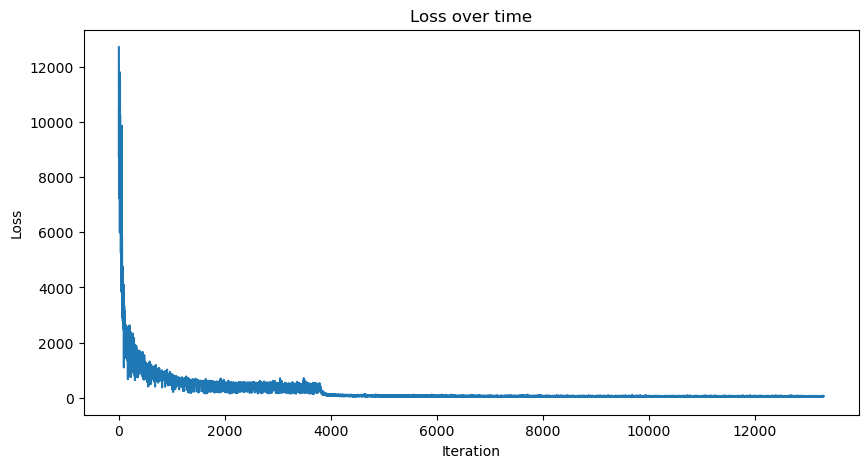

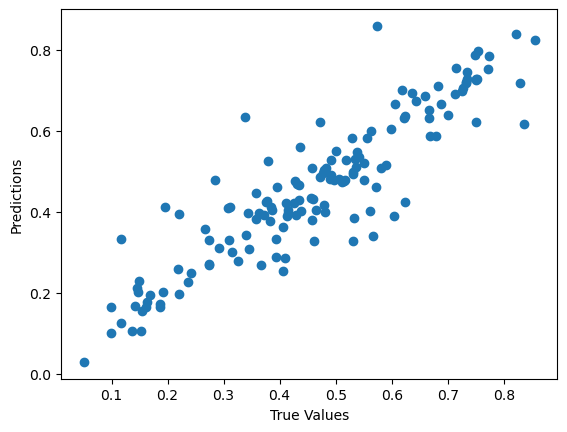

          0
0    0.2424
1    0.4966
2    0.7328
3    0.5895
4    0.2368
..      ...
142  0.6660
143  0.2743
144  0.3831
145  0.6241
146  0.5501

[147 rows x 1 columns]
     yr       temp      hum  windspeed  days_since_2011  season_FALL  \
0  2011  17.461733  89.5217  16.303713              291            1   
1  2011  26.075000  65.4583  10.374950              161            0   
2  2012  22.902500  72.2917   7.875582              642            1   
3  2011  22.119151  45.5417   9.833121              234            0   
4  2012  -2.947500  41.4583  12.374900              368            0   

   season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
0              0              0              0                0   
1              1              0              0                0   
2              0              0              0                0   
3              0              1              0                0   
4              0              0              1                0 

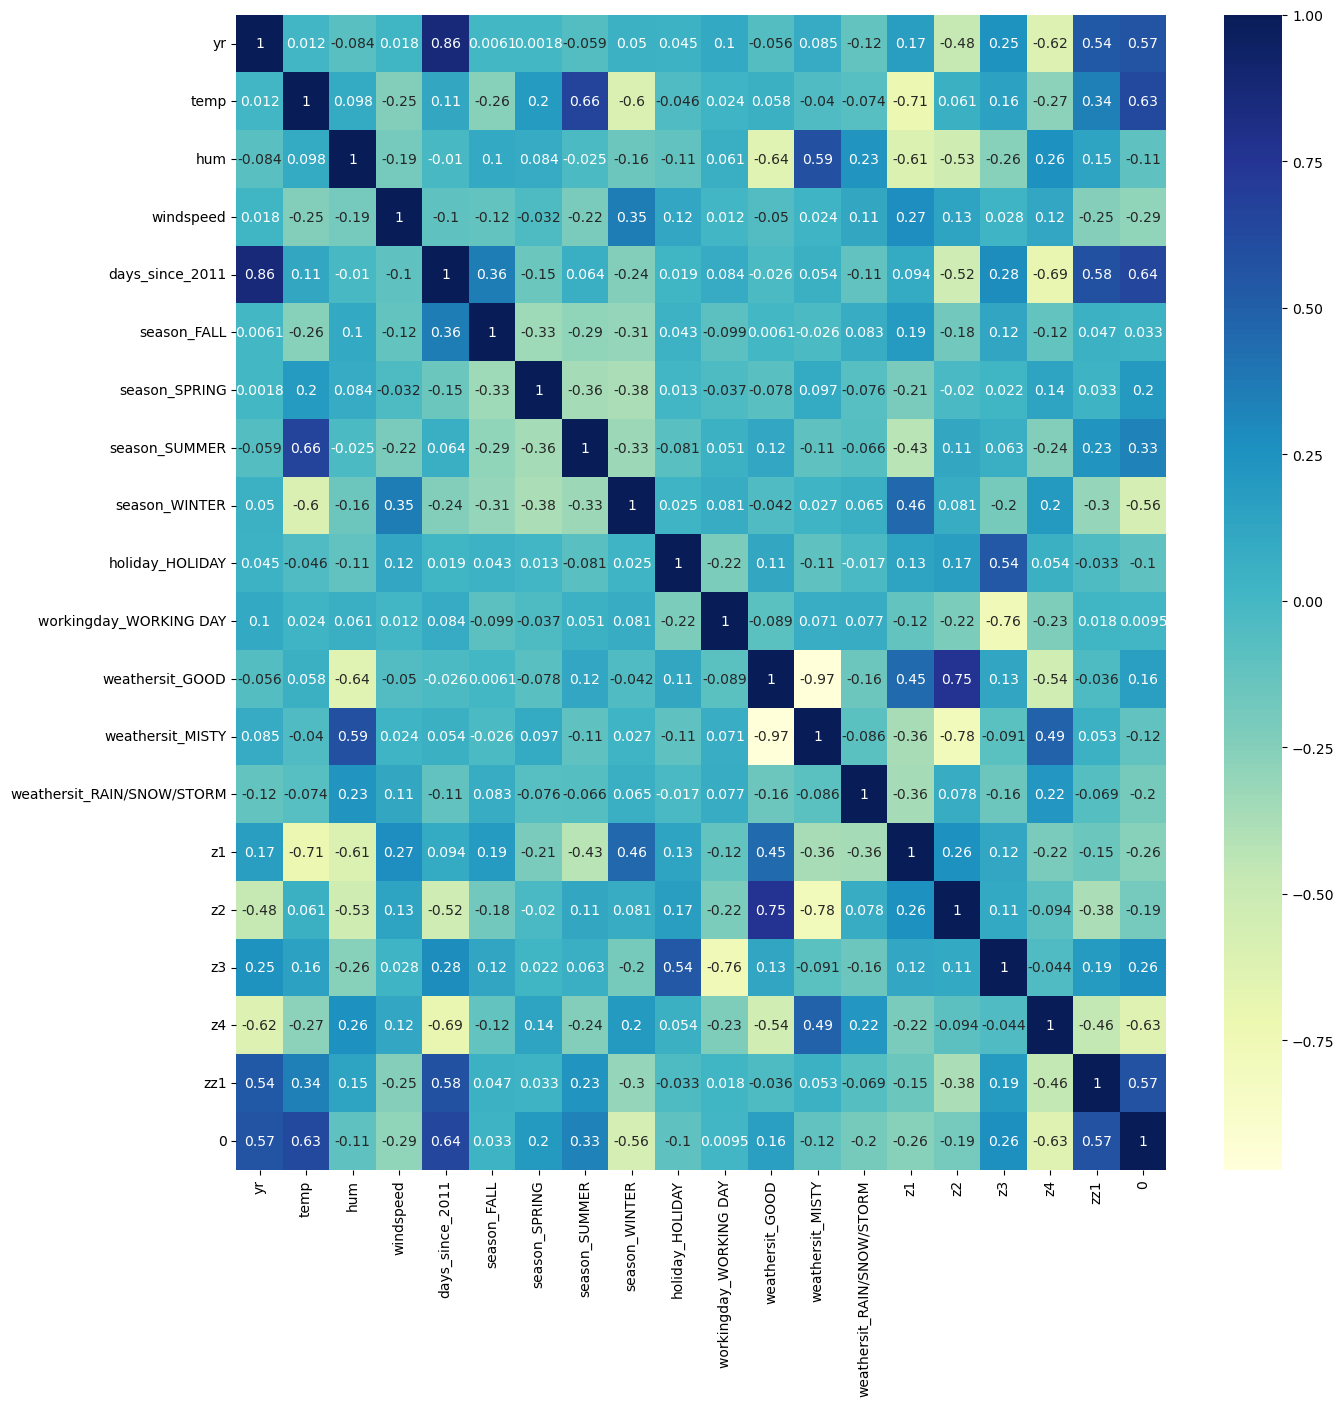

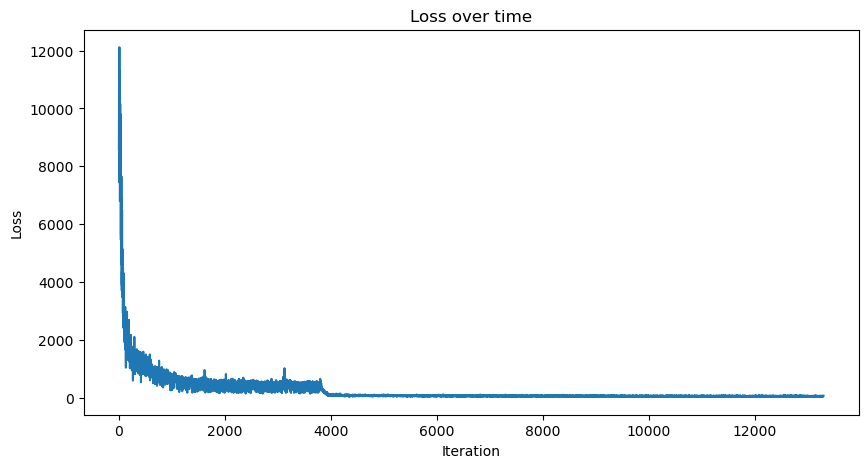

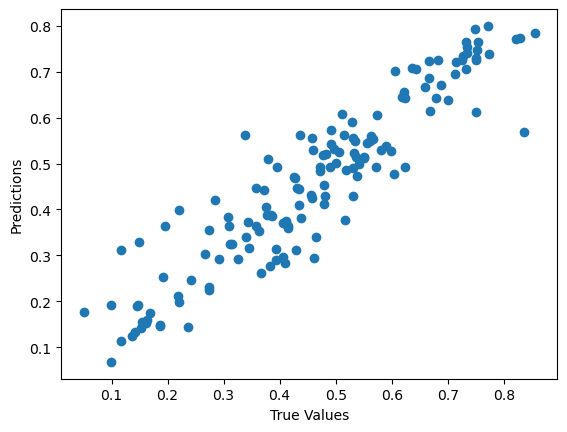

          0
0    0.2424
1    0.4966
2    0.7328
3    0.5895
4    0.2368
..      ...
142  0.6660
143  0.2743
144  0.3831
145  0.6241
146  0.5501

[147 rows x 1 columns]
     yr       temp      hum  windspeed  days_since_2011  season_FALL  \
0  2011  17.461733  89.5217  16.303713              291            1   
1  2011  26.075000  65.4583  10.374950              161            0   
2  2012  22.902500  72.2917   7.875582              642            1   
3  2011  22.119151  45.5417   9.833121              234            0   
4  2012  -2.947500  41.4583  12.374900              368            0   

   season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
0              0              0              0                0   
1              1              0              0                0   
2              0              0              0                0   
3              0              1              0                0   
4              0              0              1                0 

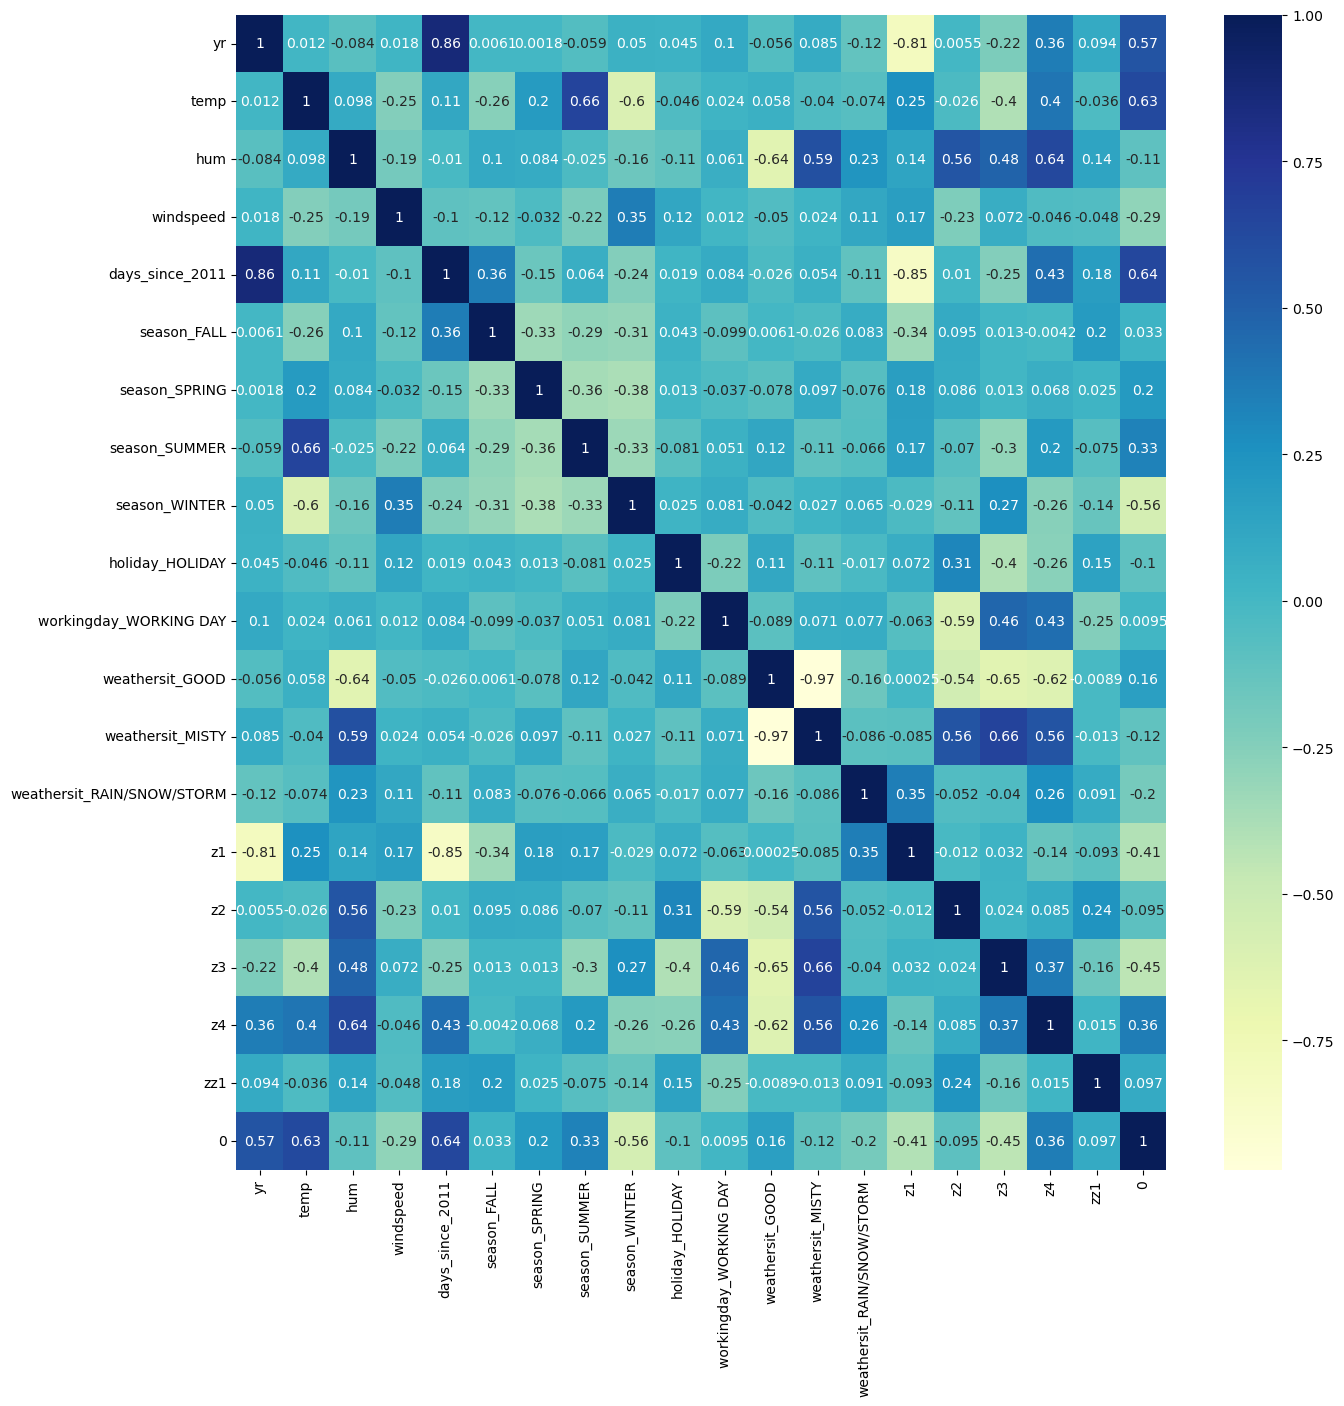

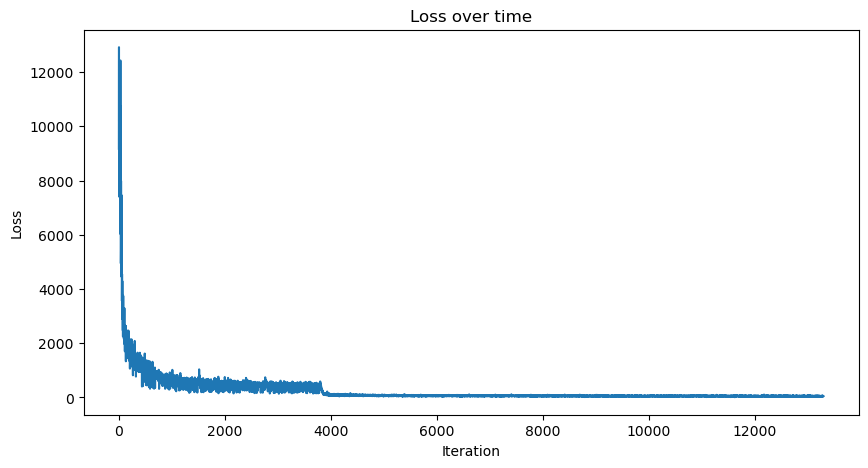

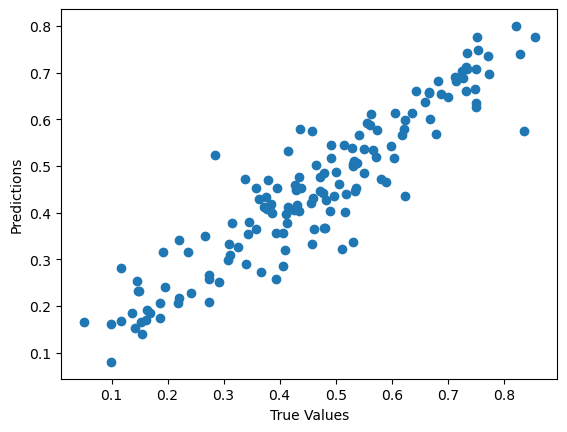

          0
0    0.2424
1    0.4966
2    0.7328
3    0.5895
4    0.2368
..      ...
142  0.6660
143  0.2743
144  0.3831
145  0.6241
146  0.5501

[147 rows x 1 columns]
     yr       temp      hum  windspeed  days_since_2011  season_FALL  \
0  2011  17.461733  89.5217  16.303713              291            1   
1  2011  26.075000  65.4583  10.374950              161            0   
2  2012  22.902500  72.2917   7.875582              642            1   
3  2011  22.119151  45.5417   9.833121              234            0   
4  2012  -2.947500  41.4583  12.374900              368            0   

   season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
0              0              0              0                0   
1              1              0              0                0   
2              0              0              0                0   
3              0              1              0                0   
4              0              0              1                0 

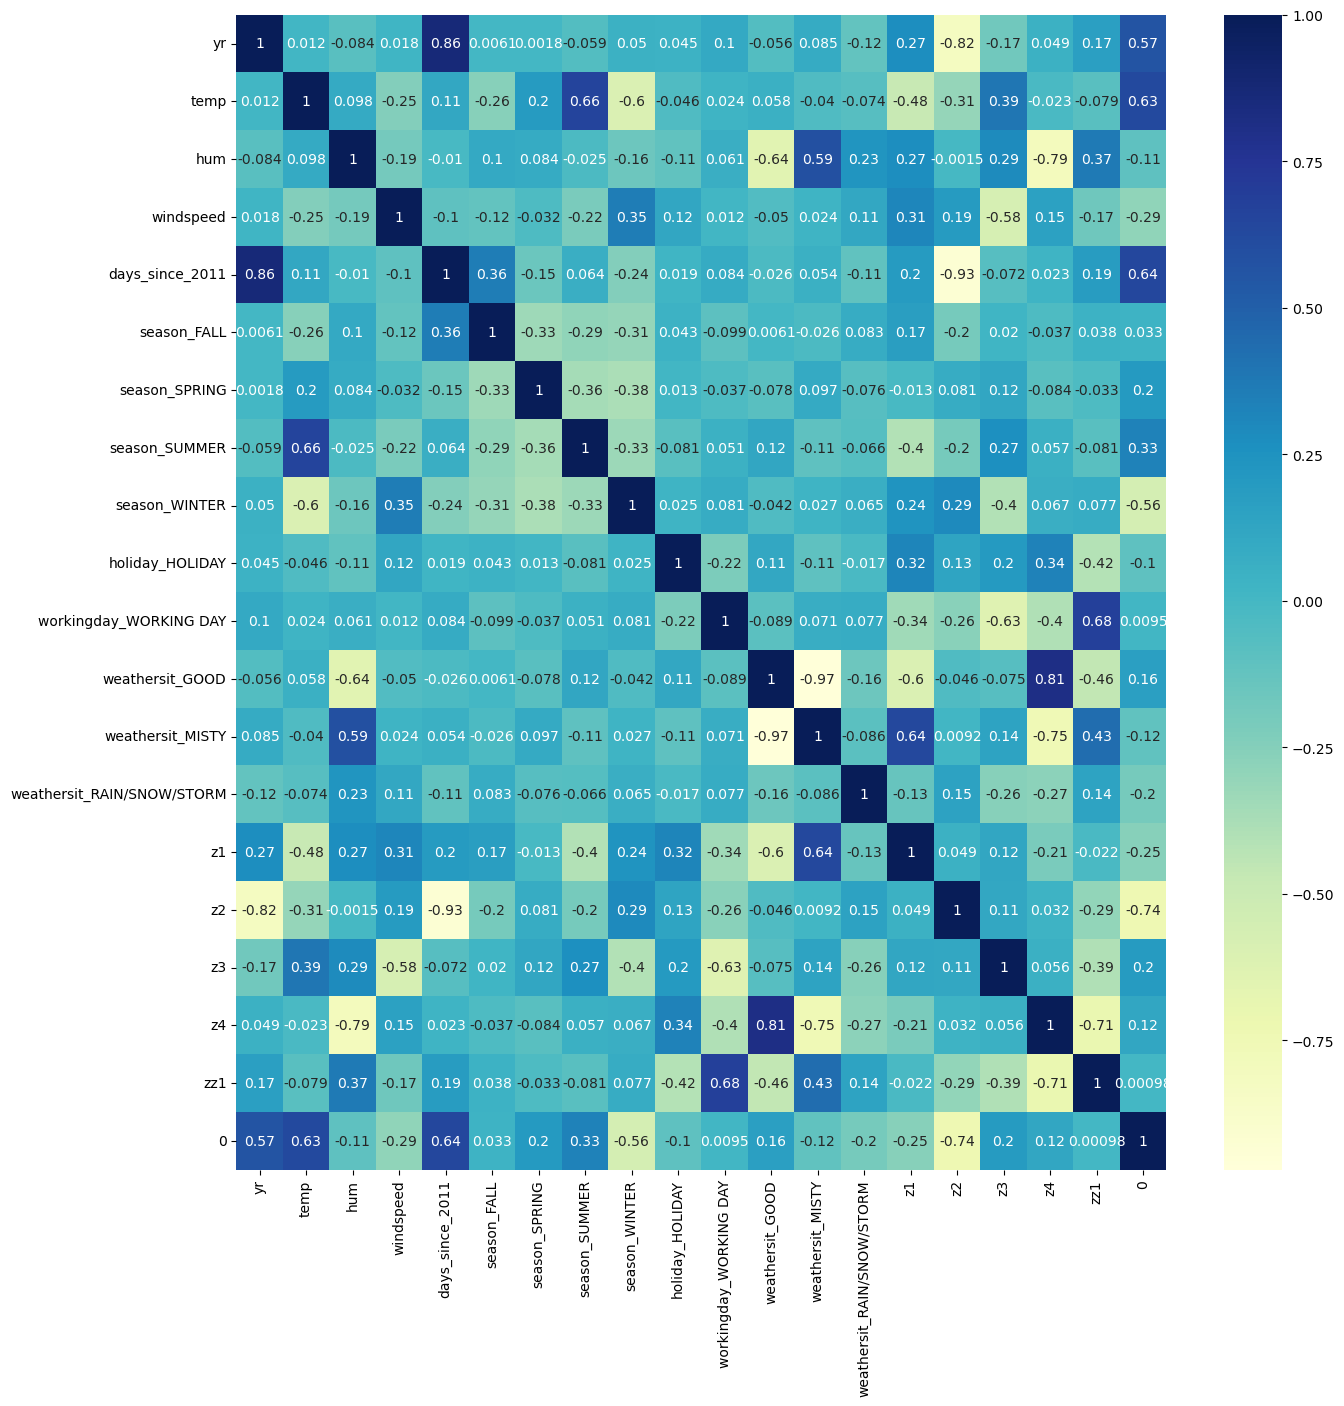

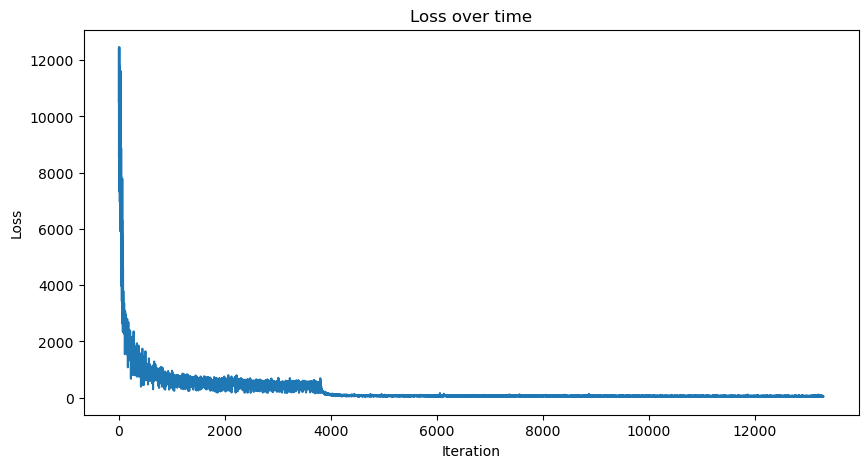

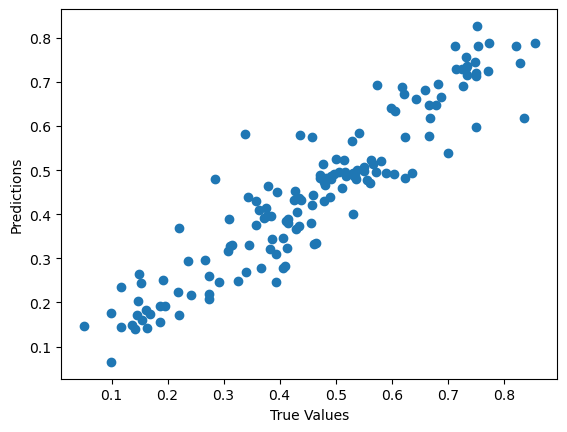

          0
0    0.2424
1    0.4966
2    0.7328
3    0.5895
4    0.2368
..      ...
142  0.6660
143  0.2743
144  0.3831
145  0.6241
146  0.5501

[147 rows x 1 columns]
     yr       temp      hum  windspeed  days_since_2011  season_FALL  \
0  2011  17.461733  89.5217  16.303713              291            1   
1  2011  26.075000  65.4583  10.374950              161            0   
2  2012  22.902500  72.2917   7.875582              642            1   
3  2011  22.119151  45.5417   9.833121              234            0   
4  2012  -2.947500  41.4583  12.374900              368            0   

   season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
0              0              0              0                0   
1              1              0              0                0   
2              0              0              0                0   
3              0              1              0                0   
4              0              0              1                0 

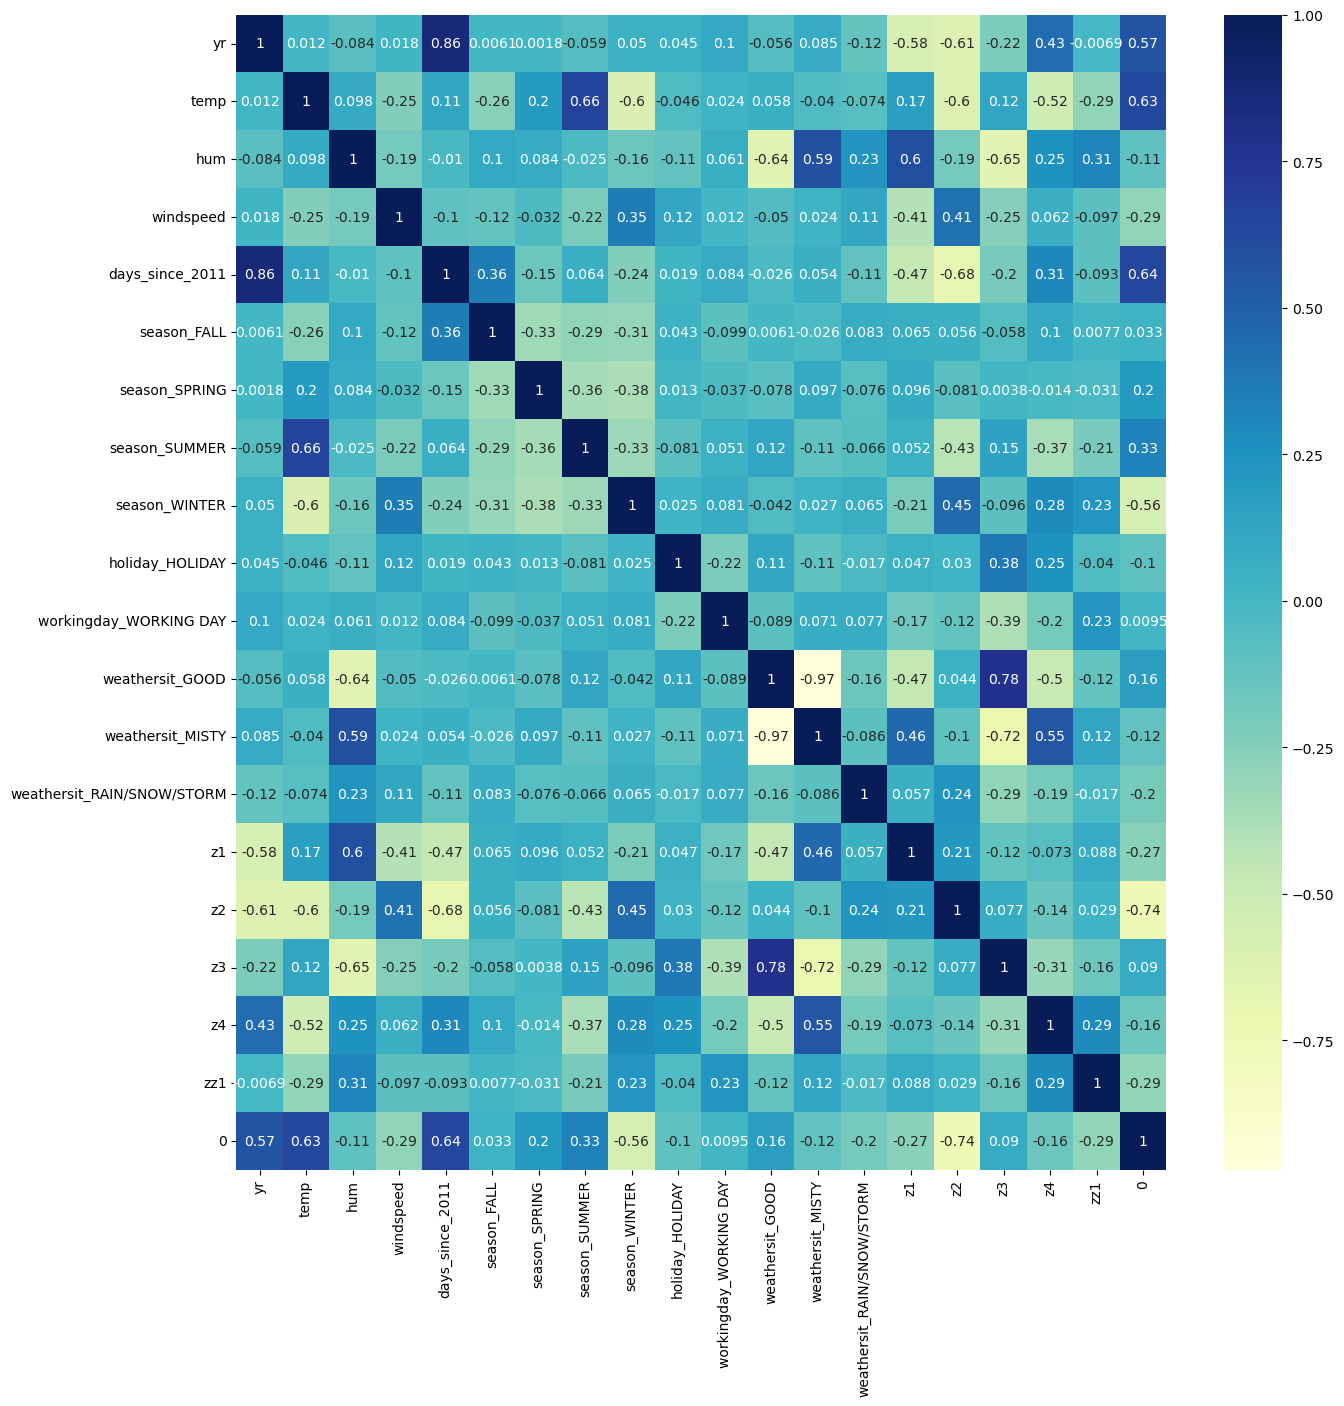

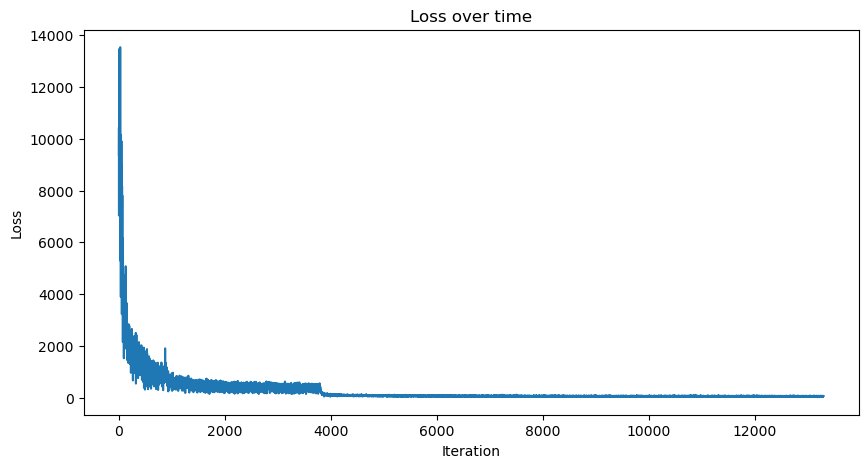

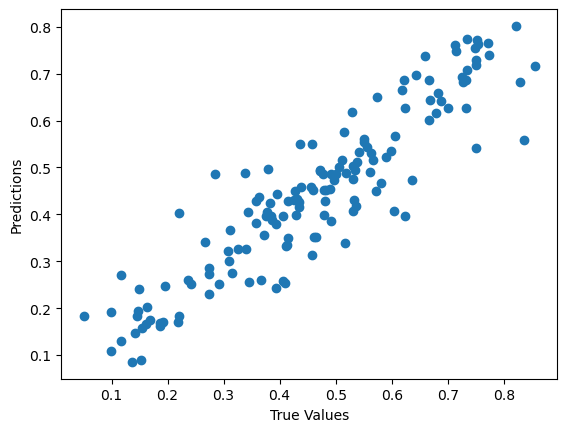

          0
0    0.2424
1    0.4966
2    0.7328
3    0.5895
4    0.2368
..      ...
142  0.6660
143  0.2743
144  0.3831
145  0.6241
146  0.5501

[147 rows x 1 columns]
     yr       temp      hum  windspeed  days_since_2011  season_FALL  \
0  2011  17.461733  89.5217  16.303713              291            1   
1  2011  26.075000  65.4583  10.374950              161            0   
2  2012  22.902500  72.2917   7.875582              642            1   
3  2011  22.119151  45.5417   9.833121              234            0   
4  2012  -2.947500  41.4583  12.374900              368            0   

   season_SPRING  season_SUMMER  season_WINTER  holiday_HOLIDAY  \
0              0              0              0                0   
1              1              0              0                0   
2              0              0              0                0   
3              0              1              0                0   
4              0              0              1                0 

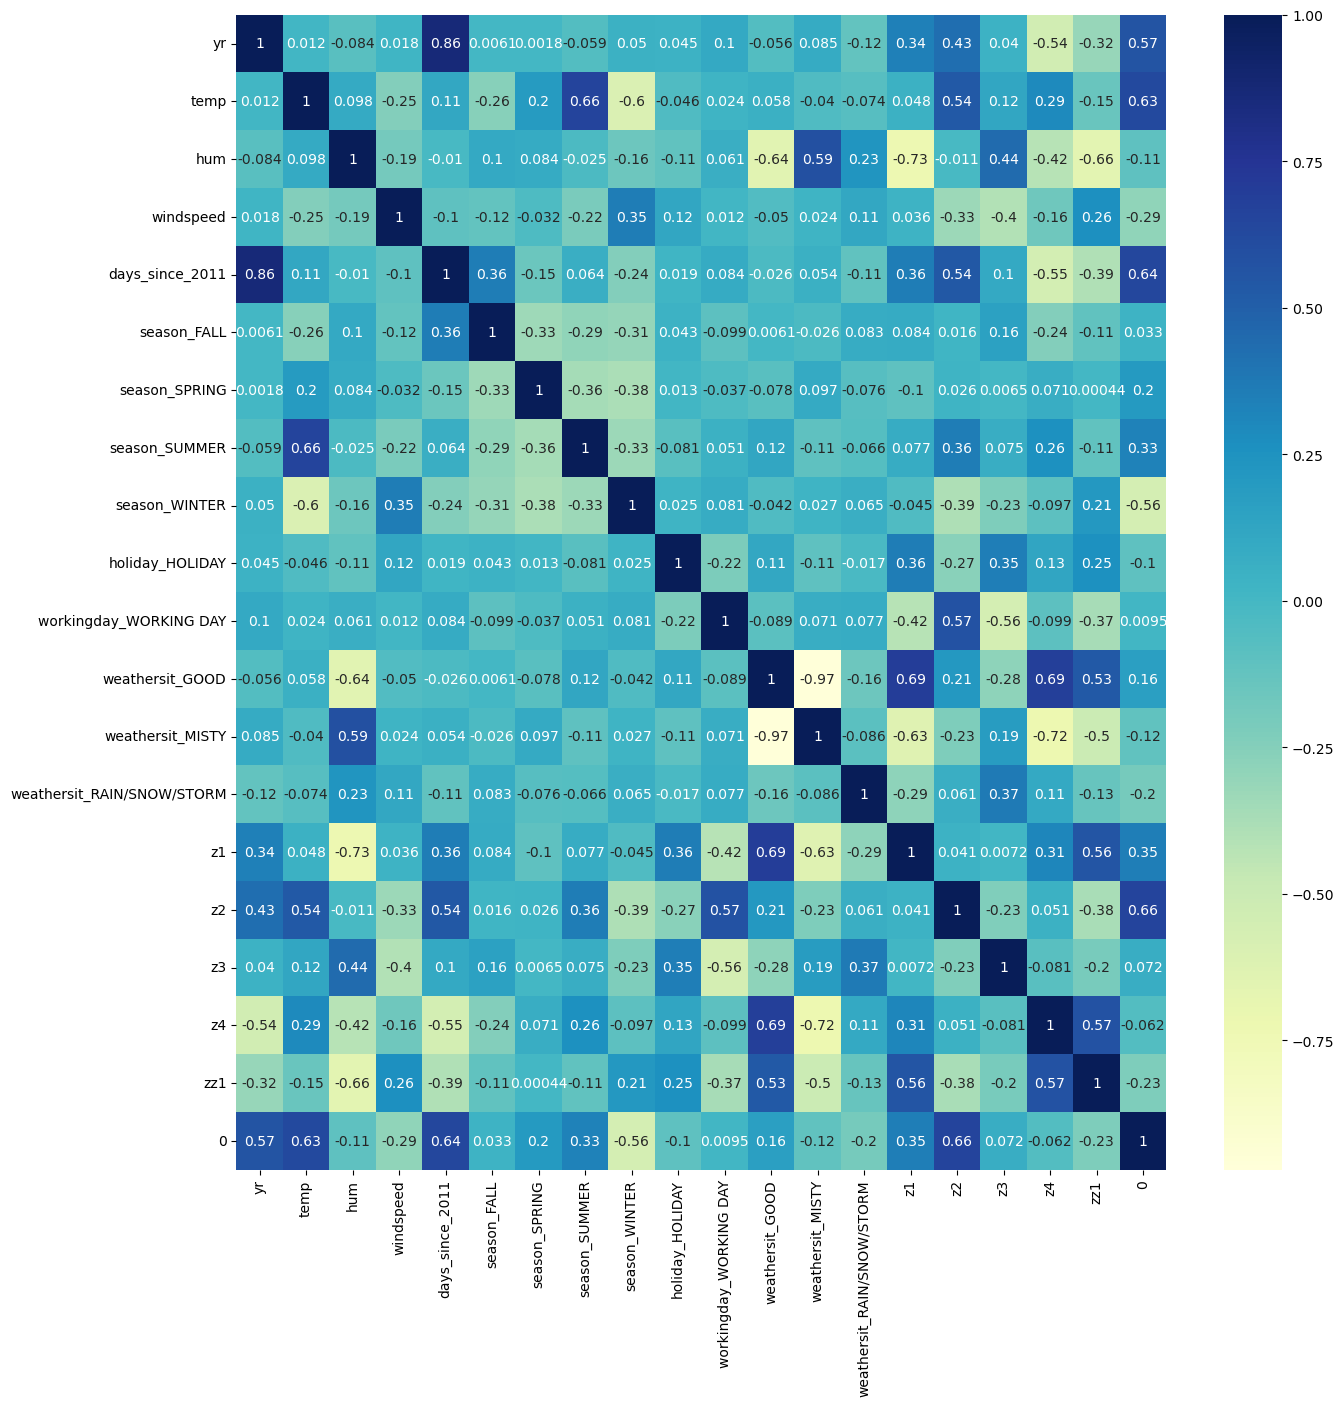

In [13]:
for config in configs:
    for i in range(5):
        mod,r,lt,ltt=train_VAE(X_train_scaled,X_test_scaled,X_test,y_train_scaled.values,y_test_scaled.values,config,'./Test',save_pictures=True,freeze_weights=True,offset=500,partial=200)
        if r>0.84:
            dict_d=dict(configs[0])
            r2_text = str(r).replace(".", "_")
            torch.save(mod,f"./Bike_rental/Final/Bike__freeze_z_and_zz_to_y_R2_{r2_text}_model.zip")
            with open(f"./Bike_rental/Final/Config_Bike__freeze_z_and_zz_to_y_R2_{r2_text}.json", 'w') as outfile:
                json.dump(dict_d, outfile)